# Show the Attach Rates of XC and Sling since Acquisition
AUTHOR: Nathan Mittleman
LAST UPDATED: 10/11/2022

Goal of this doc is to show the attach rates of Sling and XC since the acquisitions


In [58]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from IPython.core.display import display, HTML
import matplotlib.ticker as mtick
from datetime import date, datetime
from scipy.interpolate import make_interp_spline, BSpline

warnings.filterwarnings('ignore')
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.max_rows', 550)
pd.set_option('display.max_columns', 550)

import snowflake.connector 
cnx = snowflake.connector.connect(
    user='nmittleman@toasttab.com',
    account='toast.us-east-1',
    authenticator='externalbrowser'
    )

%matplotlib inline

def QueryDWH(query, cnx, col=[]):
    cur = cnx.cursor()
    cur.execute(query)
    # If there is no col input, then get the columns from the return of the
    # snowflake query
    if not col:
        df = pd.DataFrame(cur.fetchall())
        if not df.empty:
            df.columns = [desc[0] for desc in cur.description]
    else:
        df = pd.DataFrame(cur.fetchall(), columns=col)

    return df
QueryDWH("""USE DATABASE TOAST""", cnx)
QueryDWH("""USE WAREHOUSE TOAST_WH""", cnx)

,status
0,Statement executed successfully.


# Plotting Classes and Functions

In [104]:
class PlotParams:
    # A Class that defines the plot characteristics
    # Plot characteristics are any attributes that define 
    # what type of plot, line colors, styles or smoothing
    
    def __init__(self, plotStyle = 'Line', fig=None, ax=None, grid=False, linestyle = '-', colorlist = None, k = 1):
        from matplotlib import lines    
        from matplotlib.colors import is_color_like

        
        # Line Style
        if plotStyle in ['Line', 'Scatter']:
            self._plotStyle = plotStyle
        else:
            raise Exception("plotStyle must be one of: 'Line', 'Scatter'")
        
        # Grid
        if type(grid) == bool:
            self._grid = grid
        else:
            raise Exception("grid must be of Type Bool")
            
        # linestyle
        
        if (linestyle in lines.lineStyles.keys()) :
            self._linestyle = linestyle
        else:
            raise Exception(f"linestyle must be one of: {lines.lineStyles.keys()}")

        # Color List
        if colorlist is None:
             self._colorlist = ['r', 'b', 'g', 'c', 'orange', 'y', 'brown', 'grey', 'pink']
        # check to makesure the values are valid
        else:
            if type(colorlist) != list:
                raise Exception(f"colorList must be of Type List or else None")
            for color in colorlist:
                if type(color) == str:
                    colorTest = is_color_like(color) | self.is_hex_color(color)
                else:
                    colorTest = False
                if colorTest == False:
                    raise Exception(f"{color} Is Not a Valid Color")
            self._colorlist = colorlist

            
        # Fig and Ax
        if (fig is None) & (ax is None):
            self._fig, self._ax = plt.subplots(figsize=(20,10))
            plt.close(fig)
        elif ((fig is not None) + (ax is not None)) == 2:
            self._fig = fig
            self._ax = ax
        else:
            raise Exception("Need to Input both 'ax' and 'fig' parameters or neither, but cannot input one and not the other")            
            
            
        self._k = k
        
        self._colorCounter = 0

    def is_hex_color(self, input_string):
        import re
        HEX_COLOR_REGEX = r'^#([A-Fa-f0-9]{6}|[A-Fa-f0-9]{3})$'        
        regexp = re.compile(HEX_COLOR_REGEX)
        if regexp.search(input_string):
            return True
        return False
    
    def reset_color_counter(self):
        self._colorCounter = 0
        
    def increment_color_counter(self):
        self._colorCounter += 1  
        self._colorCounter = self._colorCounter % len(self._colorlist)
        
    def get_next_color(self):
        next_color = self._colorlist[self._colorCounter]
        self.increment_color_counter()
        return next_color
        
class AxisParams:
    # Definition of parameters of a plot's axis
    def __init__(self, title = '', axisFormat = None, rotation = 0, spacing = 'smart', fontsize = 14, color = 'k'):
        self._title = title
        self._format = axisFormat
        self._rotation = rotation
        self._spacing = spacing
        self._fontsize = fontsize
        self._color = color
        
class TitleParams:
    # Definition of parameters of a plot's title
    def __init__(self, title = '', fontsize = 14, color='k'):
        self._title = title
        self._fontsize = fontsize
        self._color = color

        
class LegendParams:
    # Definition of parameters of a plot's legend
    def __init__(self, show = True, location = 'best', size=30):
        self._show = show # A boolean. True means display legend, false does not
        self._location = location # The location of the legend
        self._size = size # Size of the legend text


In [3]:
def GetSmoothedSeries(index, data, k ):
        if k == 1:
            return index, data
            
        else:
            xNew = np.linspace(index.min(), index.max(), len(index)*20 - 19)
        if len(index) < 4:
            return xNew, yNew

        tmpSpl = make_interp_spline(index, data, k=k)

        yNew = tmpSpl(xNew)    
        
        return xNew, yNew

In [4]:
def FormatPlot(ax, xAxisParams, yAxisParams, titleParams, maxAxis, xAxis):
                
    xAxisList = maxAxis[xAxis]
    xAxisInd = maxAxis['index']
    
    if xAxisParams._format == 'i':
        xAxisList = xAxisList.astype(int)
    elif xAxisParams._format:
        xAxisList = pd.to_datetime(xAxisList).dt.strftime(xAxisParams._format)           
    
    if xAxisParams._spacing == 'smart':
        spacing = int(np.ceil(len(xAxisList.to_numpy()) / 6))
    else:
        spacing = xAxisParams._spacing
    
    
    ax.set_xticks(xAxisInd.to_numpy()[::spacing])
    ax.set_xticklabels(xAxisList.to_numpy()[::spacing])

    if yAxisParams._format == '%':
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
    elif yAxisParams._format == '$':
        ax.yaxis.set_major_formatter('${x:1.0f}')   
    elif yAxisParams._format == '2$':
        ax.yaxis.set_major_formatter('${x:1.2f}') 

    ax.tick_params(axis='x', labelsize=24, rotation=xAxisParams._rotation, colors=xAxisParams._color)
    ax.tick_params(axis='y', labelsize=24, colors=yAxisParams._color)

    ax.set_xlabel(xAxisParams._title, fontsize=xAxisParams._fontsize, color=xAxisParams._color)
    ax.set_ylabel(yAxisParams._title, fontsize=yAxisParams._fontsize, color=yAxisParams._color)
    ax.set_title(titleParams._title, fontsize=titleParams._fontsize, color=titleParams._color)    

In [5]:
def GetPlotStyleParameters(col, key, numGroups, numCols, plotParams,  colorCounter):
    if numGroups == 1:
        label = f'{col}'
    elif numCols == 1:
        label = f'{key}'
    else:
        label = f'{key} - {col}'

    color = plotParams.get_next_color()

    if key == 'Total':
        color = 'k'

    if key == 'Total':
        linestyle = '--'
    else:
        linestyle = plotParams._linestyle                



    return color, linestyle, label, colorCounter

In [183]:
def PlotSmoothLine(df, xAxis, colList, 
                   group = None, 
                   plotParams = None,
                   xAxisParams = None,
                   yAxisParams = None,
                   legendParams = None,
                   titleParams = None,
                   smoothing = True, 
                   savefig = None, showPlot=True, verbose = False):
    
    # Initializing Inputs
    if not plotParams:
        plotParams = PlotParams()
    fig = plotParams._fig
    ax = plotParams._ax
    
    if not titleParams:
        titleParams = TitleParams()
    
    if not xAxisParams:
        xAxisParams = AxisParams()
        
    if not yAxisParams:
        yAxisParams = AxisParams()
    
    if not legendParams:
        legendParams = LegendParams()
   
    if group is None:
        group = '__temp_group'
        df[group] = 'A'
    
    # If the column input is a column name - turn it into a list
    if type(colList) == str:
        colList = [colList]
    numCols = len(colList)    
    numGroups = df[group].nunique()
    
    # Create a master axis which has all of the axis points for each grouping
    maxAxis = pd.DataFrame(df[xAxis].unique(), columns = [xAxis])
    maxAxis.reset_index(inplace=True)
    
    colorCounter = 0
    grpbyObj = df.groupby([group])
    
    # Iterate through each col in the col list and each group in the grouping and plot that
    for col in colList:
        for key, grp in grpbyObj:
            
            # Ensure that the axes always align - this is done by merging the data to the maxAxis
            # any nulls are forward fills and any leading nulls are zeroed
            grp = maxAxis.merge(grp, how='left')
            grp[group] = key
            grp[col].fillna(method='ffill', inplace=True)
            grp[col].fillna(0, inplace=True)
            grp = grp.reset_index(drop=True).reset_index()

            # if k = 1 (no smoothing, then the axes and data points remain as they are)
            if plotParams._k == 1:
                xNew = grp['index']
                yNew = grp[col]
            else:
                # if there is smoothing - create the new smoothed data points
                xNew, yNew = GetSmoothedSeries(grp['index'], grp[col], plotParams._k )
            
            # Get the plot / line attributes
            color, linestyle, label, colorCounter = GetPlotStyleParameters(col, key, numGroups, numCols, plotParams, colorCounter)
            
            #
            if plotParams._plotStyle == 'Line':
                ax.plot(xNew, yNew, label = label, c=color, linestyle=linestyle)
            elif plotParams._plotStyle == 'Scatter':     
                ax.scatter(xNew, yNew, label = label, c=color)
    
    FormatPlot(ax, xAxisParams, yAxisParams, titleParams, maxAxis,xAxis)

    if plotParams._grid:
        ax.grid()

    if legendParams._show:
        ax.legend(loc=legendParams._location, prop={'size': legendParams._size})

    if savefig:
        plt.savefig(f'{savefig}.png', bbox_inches='tight')

    if showPlot:
        display(fig)

    return fig, ax

# Data Ingestions

In [10]:
query = """
        SELECT customer_id
             , restaurant_Type
             , parent_market_Segment
             , opportunity_close_date
             , pos_first_order_Date
        FROM analytics_core.customer
        """
cust = QueryDWH(query, cnx, ['Customer Id', 'Restaurant Type', 'Segment', 'Booked Date', 'FOD'])
for col in ['Booked Date', 'FOD']:
    cust[col] = pd.to_datetime(cust[col]).dt.date



In [8]:
query = """

            SELECT opp.customer_id 
                 , opp.opportunity_type AS opp_type
                 , opp.opportunity_close_date AS close_date 
                 , opp.salesforce_opportunityid
                 
                 , oli.product_name
                 , oli.product_sku
                 , oli.total_price
                 , oli.item_quantity
                 
            FROM gtm.opportunity opp      
            LEFT JOIN gtm.opportunity_line_item_fact oli 
            ON opp.salesforce_opportunityid = oli.salesforce_opportunityid
            AND oli.product_name IN ('Scheduling Pro', 
                                     'Scheduling Lite', 
                                     'xtraChef Pro', 
                                     'xtraChef Lite', 
                                     'Recipe Costing',
                                     'Inventory Management',
                                     'Invoice Automation')


            WHERE opp.opportunity_iswon = True
            AND opportunity_close_date >= '2021-07-01'
        """

oppModules = QueryDWH(query, cnx, ['Customer Id', 'Opp Type', 'Close Date', 'Opp Id', 'Module', 'Module SKU', 'Module Price', 'Module Qty'])
oppModules['Close Date'] = pd.to_datetime(oppModules['Close Date']).dt.date
for col in ['Module Price', 'Module Qty']:
    oppModules[col] = oppModules[col].astype(float)
oppModules['Close Month'] = pd.to_datetime(oppModules['Close Date'].astype("datetime64[M]")).dt.date
oppModules['Close Week'] = pd.to_datetime(oppModules['Close Date']).dt.to_period('W').apply(lambda r: r.start_time).dt.date


## Data Exploration

In [200]:
# tmp = oppModules[(oppModules[''])]
oppModules.sample()
xcModules = ['xtraChef Lite', 'xtraChef Pro', 'Recipe Costing', 'Inventory Management', 'Invoice Automation']
slingModules = ['Scheduling Lite', 'Scheduling Pro']

oppModules['XC'] = np.where(oppModules['Module'].isin(xcModules), True, False)

oppModules['Sling'] = np.where(oppModules['Module'].isin(slingModules), True, False)

opps = oppModules.groupby(['Customer Id', 'Opp Type', 'Close Date', 'Close Week', 'Close Month', 'Opp Id'])[['XC', 'Sling']].sum().reset_index()
opps['XC'] = opps['XC'] > 0
opps['Sling'] = opps['Sling'] > 0

In [201]:
nbos = opps[opps['Opp Type'] == 'New Business']


In [202]:
currWeek = pd.to_datetime(pd.to_datetime(date.today()).to_period('W').start_time).date()

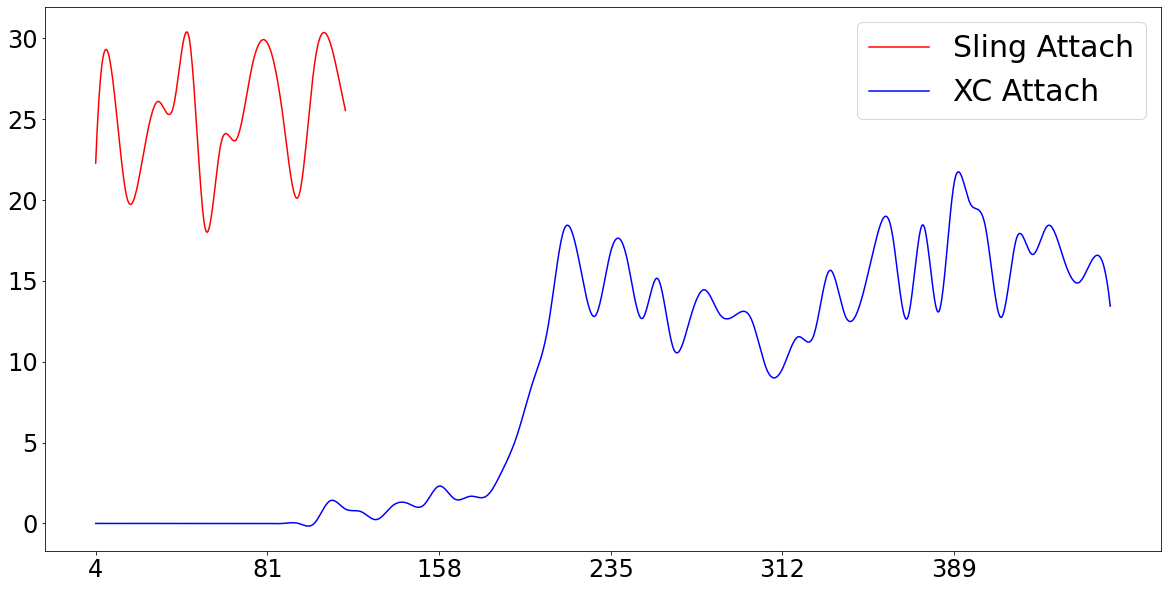

In [203]:
slingAttach = nbos[nbos['Close Date'] < currWeek]
slingAttach['Acquisition Date'] = date(2022,6,10)
slingAttach['Days From Acquisition'] = (slingAttach['Close Week'] - slingAttach['Acquisition Date']).dt.days

slingAttach = slingAttach[slingAttach['Days From Acquisition'] > 0].groupby(['Days From Acquisition']).agg({'Opp Id': 'nunique', 'XC': 'sum', 'Sling':'sum'}).reset_index()
slingAttach['Sling Attach'] = np.round(100 * slingAttach['Sling'] / slingAttach['Opp Id'], 2)
slingAttach = slingAttach[['Days From Acquisition', 'Sling Attach']]


xcAttach = nbos[nbos['Close Date'] < currWeek]
xcAttach['Acquisition Date'] = date(2021,7,1)
xcAttach['Days From Acquisition'] = (xcAttach['Close Week'] - xcAttach['Acquisition Date']).dt.days

xcAttach = xcAttach[xcAttach['Days From Acquisition'] > 0].groupby(['Days From Acquisition']).agg({'Opp Id': 'nunique', 'XC': 'sum', 'Sling':'sum'}).reset_index()
xcAttach['XC Attach'] = np.round(100 * xcAttach['XC'] / xcAttach['Opp Id'], 2)
xcAttach = xcAttach[['Days From Acquisition', 'XC Attach']]


plotParams = PlotParams(k=3, colorlist = ['r'])
fig, ax = PlotSmoothLine(slingAttach, 'Days From Acquisition', ['Sling Attach'], plotParams = plotParams, showPlot = False)
plotParams = PlotParams(k=3, fig=fig, ax=ax, colorlist = ['b'])
fig, ax = PlotSmoothLine(xcAttach, 'Days From Acquisition', ['XC Attach'], plotParams = plotParams)

In [204]:
tmp = oppModules[(oppModules['Close Month'] == date(2022,9,1)) & (oppModules['Module SKU'] == 'SUB037') & (oppModules['Opp Type'] == 'New Business')]
cid = tmp.sample()['Customer Id'].min()

In [205]:
oppModules[oppModules['Customer Id'] == cid]

,Customer Id,Opp Type,Close Date,Opp Id,Module,Module SKU,Module Price,Module Qty,Close Month,XC,Sling,Close Week
121836,293afbe94c85226073c112e71073307e,New Business,2022-09-06,0064W00001D6Z66QAF,Inventory Management,SUBCXC03,40.00,1.0,2022-09-01,True,False,2022-09-05
121837,293afbe94c85226073c112e71073307e,New Business,2022-09-06,0064W00001D6Z66QAF,xtraChef Pro,SUBPXC01,0.00,1.0,2022-09-01,True,False,2022-09-05
121838,293afbe94c85226073c112e71073307e,New Business,2022-09-06,0064W00001D6Z66QAF,Invoice Automation,SUBCXC01,143.20,1.0,2022-09-01,True,False,2022-09-05
121839,293afbe94c85226073c112e71073307e,New Business,2022-09-06,0064W00001D6Z66QAF,Scheduling Pro,SUB037,51.75,1.0,2022-09-01,False,True,2022-09-05
121840,293afbe94c85226073c112e71073307e,New Business,2022-09-06,0064W00001D6Z66QAF,Recipe Costing,SUBCXC02,40.00,1.0,2022-09-01,True,False,2022-09-05


In [206]:
opps[opps['Customer Id'] == cid]

,Customer Id,Opp Type,Close Date,Close Week,Close Month,Opp Id,XC,Sling
33979,293afbe94c85226073c112e71073307e,New Business,2022-09-06,2022-09-05,2022-09-01,0064W00001D6Z66QAF,True,True


,Close Month,Opp Id,XC,Sling,Sling Attach,XC Attach
0,2021-07-01,2406,0,8,0.33,0.00
1,2021-08-01,2501,0,11,0.44,0.00
2,2021-09-01,3195,0,14,0.44,0.00
3,2021-10-01,2685,19,12,0.45,0.71
4,2021-11-01,2716,25,16,0.59,0.92
5,2021-12-01,3495,61,37,1.06,1.75
6,2022-01-01,2229,254,176,7.90,11.40
7,2022-02-01,2486,389,436,17.54,15.65
8,2022-03-01,3657,467,818,22.37,12.77
9,2022-04-01,3025,392,658,21.75,12.96


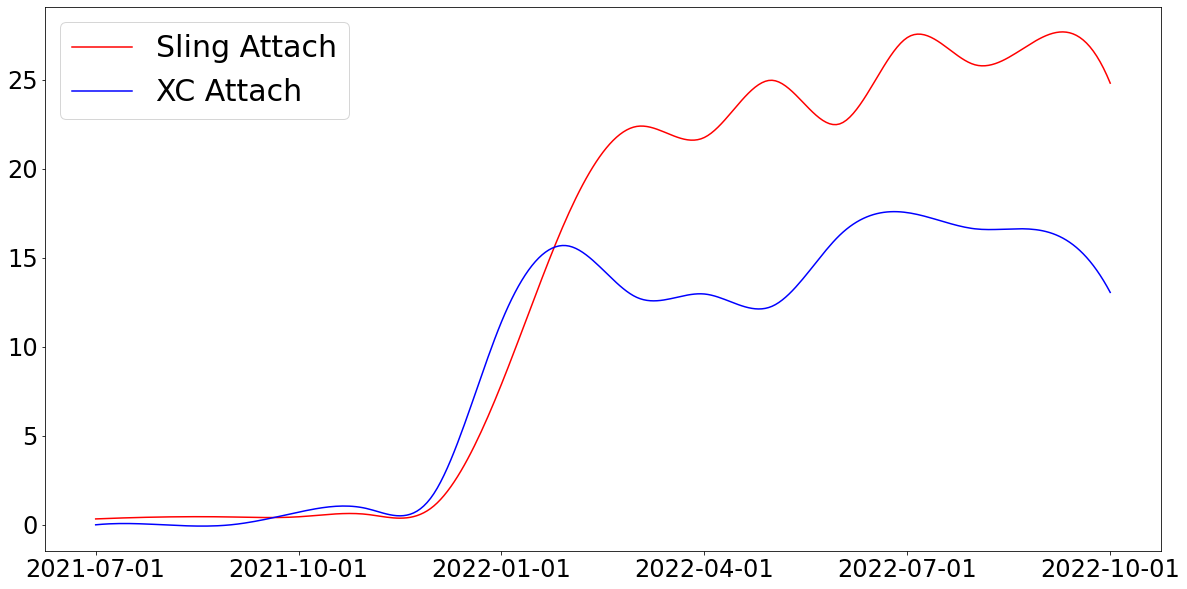

In [207]:
attach = nbos[nbos['Close Date'] < currWeek]


attach = attach.groupby(['Close Month']).agg({'Opp Id': 'nunique', 'XC': 'sum', 'Sling':'sum'}).reset_index()
attach['Sling Attach'] = np.round(100 * attach['Sling'] / attach['Opp Id'], 2)
attach['XC Attach'] = np.round(100 * attach['XC'] / attach['Opp Id'], 2)
display(attach)

attach = attach[['Close Month', 'Sling Attach', 'XC Attach']]

plotParams = PlotParams(k=3, colorlist = ['r', 'b'])
fig, ax = PlotSmoothLine(attach, 'Close Month', ['Sling Attach', 'XC Attach'], plotParams = plotParams, showPlot = True)

